In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random

load data

In [2]:
def insertGambar(folder):
    images = [] 
    filenames = [] 
    labels = [] 

    for label in os.listdir(folder): 
        for filename in os.listdir("dataset/"+label): 
            img = cv.imread(os.path.join("dataset/"+label,filename), 255) 
            filenames.append(filename) 
            labels.append(label) 
            if img is not None: 
                images.append(img) 
    return images, filenames, labels 

images, filenames, labels = insertGambar("dataset")

resize

In [3]:
def resize_image(image_list, scale_percent):
    resized_images = []
    for img in image_list:
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        resized = cv.resize(img, dim, interpolation=cv.INTER_AREA)
        resized_images.append(resized)
    return resized_images

In [4]:
scaled_percent = 150
resized_images = resize_image(images, scaled_percent)

menampilkan gambar yg sudah di resize

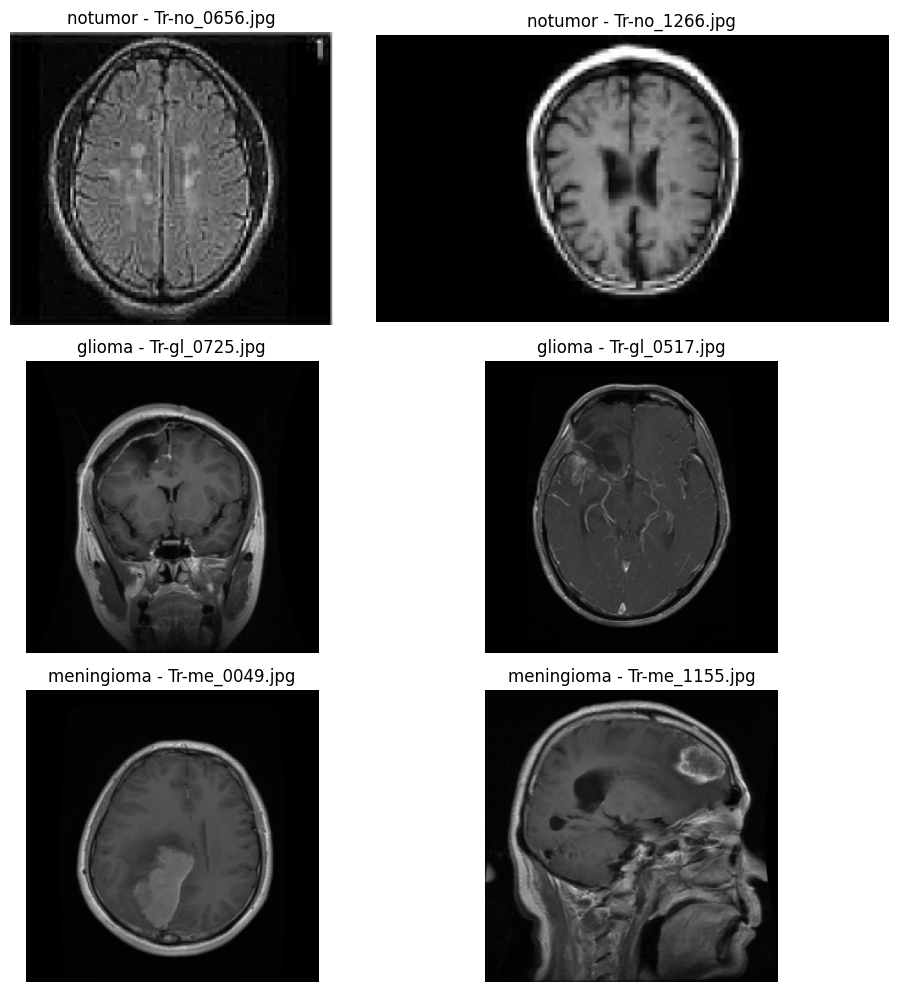

In [5]:
labels_to_display = ['notumor', 'glioma', 'meningioma']
max_images_per_label = 2

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

for row, label in enumerate(labels_to_display):

    filtered_images = [(img, filename) for img, filename, img_label in zip(resized_images, filenames, labels) if img_label == label]
    
    random.shuffle(filtered_images)
    
    for col in range(min(max_images_per_label, len(filtered_images))):
        img, filename = filtered_images[col]
        ax = axes[row, col]
        ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax.set_title(f"{label} - {filename}")
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

augmentasi

rotasi

In [6]:
def rotasi(derajat, citra):
    if len(citra.shape) == 2:
        citra = cv.cvtColor(citra, cv.COLOR_GRAY2RGB)

    panjang, lebar, _ = citra.shape 
    Rotasi_img = np.zeros(citra.shape, dtype=citra.dtype)

    sudut = derajat * (np.pi / 180)
    tengahx = panjang / 2
    tengahy = lebar / 2

    for i in range(panjang):
        for j in range(lebar):
            x = int((i - tengahx) * np.cos(sudut) - (j - tengahy) * np.sin(sudut) + tengahx)
            y = int((i - tengahx) * np.sin(sudut) + (j - tengahy) * np.cos(sudut) + tengahy)
            if 0 <= x < panjang and 0 <= y < lebar:
                Rotasi_img[i][j] = citra[x][y]

    return Rotasi_img

In [7]:
labels_to_display = ['notumor', 'glioma', 'meningioma']
sudut_rotasi = [90, 125, 180, 270]

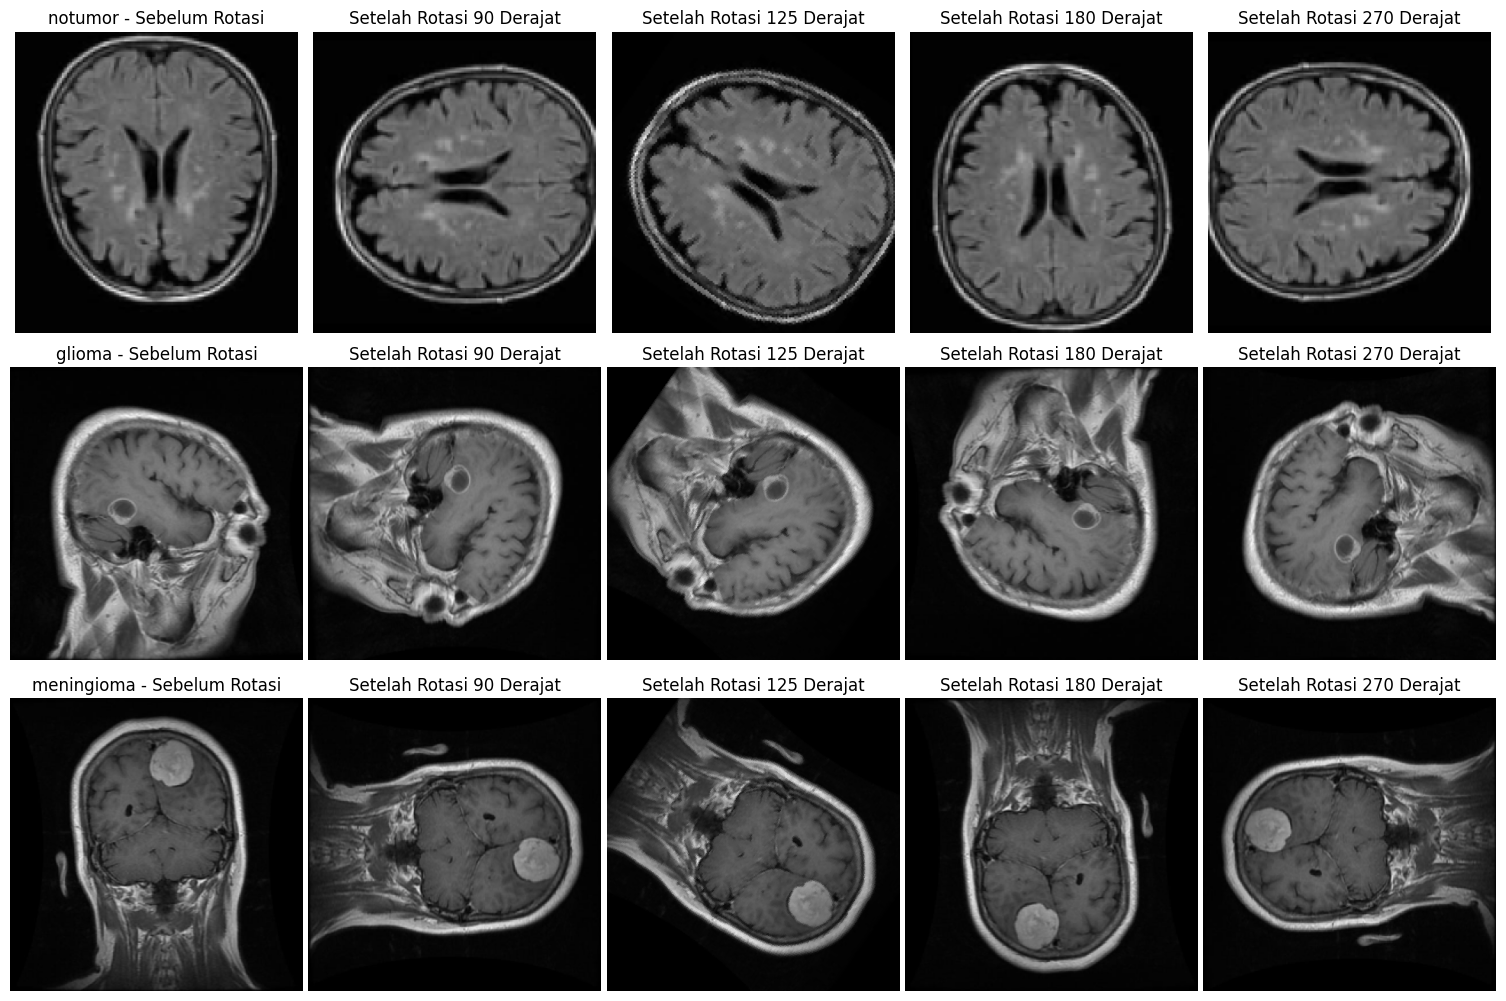

In [8]:
fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=len(sudut_rotasi) + 1, figsize=(15, 10))

for row, label in enumerate(labels_to_display):

    filtered_images = [(img, filename) for img, filename, img_label in zip(resized_images, filenames, labels) if img_label == label]
    random.shuffle(filtered_images)
    citra, filename = filtered_images[0]
    
    if citra.shape[-1] == 1:
        citra = cv.cvtColor(citra, cv.COLOR_GRAY2RGB)

    ax = axes[row, 0]
    ax.imshow(cv.cvtColor(citra, cv.COLOR_BGR2RGB))
    ax.set_title(f'{label} - Sebelum Rotasi')
    ax.axis('off')
    
    for col, sudut in enumerate(sudut_rotasi):
        rotated_image = rotasi(sudut, citra)
        rotated_image = np.clip(rotated_image, 0, 255).astype(np.uint8) 
        ax = axes[row, col+1]
        ax.imshow(cv.cvtColor(rotated_image, cv.COLOR_BGR2RGB))
        ax.set_title(f'Setelah Rotasi {sudut} Derajat')
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=0.5)
plt.show()

thresholding

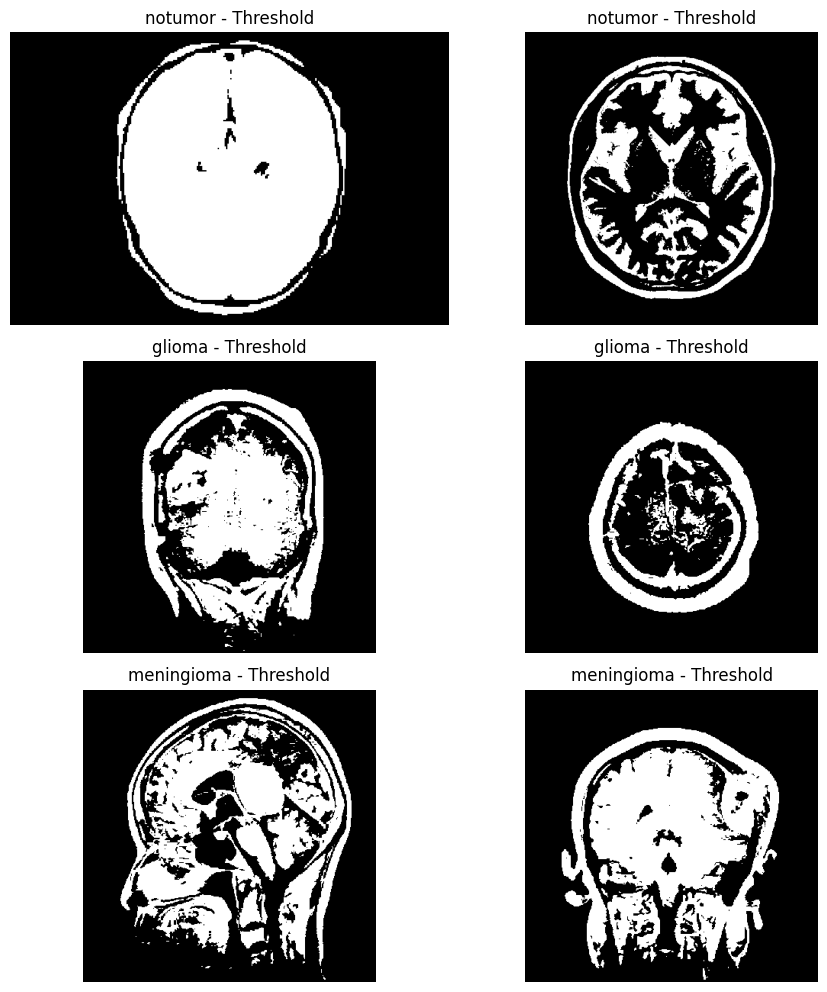

In [9]:
def apply_threshold(image_list):
    thresholded_images = []
    for img in image_list:
        if len(img.shape) == 3 and img.shape[-1] == 3:
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray_img = img
        _, thresholded_img = cv.threshold(gray_img, 60, 255, cv.THRESH_BINARY)
        thresholded_images.append(thresholded_img)
    return thresholded_images

sampled_images = []
sampled_labels = []
for label in labels_to_display:
    filtered_images = [img for img, img_label in zip(resized_images, labels) if img_label == label]
    sampled = random.sample(filtered_images, min(max_images_per_label, len(filtered_images)))
    sampled_images.extend(sampled)
    sampled_labels.extend([label] * len(sampled))

thresholded_images = apply_threshold(sampled_images)

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

for row, label in enumerate(labels_to_display):
    filtered_images = [(img, filename) for img, filename, img_label in zip(thresholded_images, sampled_labels, sampled_labels) if img_label == label]
    
    for col in range(min(max_images_per_label, len(filtered_images))):
        img, filename = filtered_images[col]
        ax = axes[row, col]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{label} - Threshold")
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

deteksi tepi canny

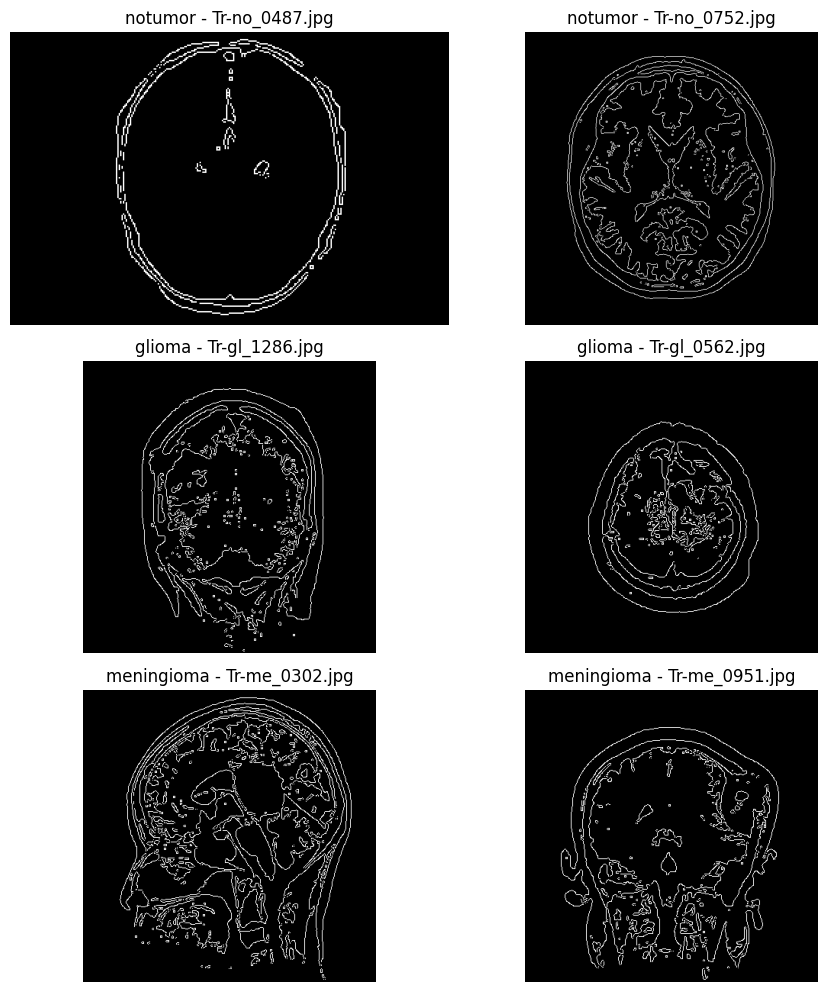

In [10]:
edge_detected_images = []
lower_bound = 100
upper_bound = 200

for img in thresholded_images:
    edge_detected_img = cv.Canny(img, lower_bound, upper_bound)
    edge_detected_images.append(edge_detected_img)

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

index = 0
for row, label in enumerate(labels_to_display):
    filtered_filenames = [filename for filename, img_label in zip(filenames, labels) if img_label == label]
    random.shuffle(filtered_filenames)
    for col in range(max_images_per_label):
        if index < len(edge_detected_images):
            ax = axes[row, col]
            ax.imshow(edge_detected_images[index], cmap='gray')
            ax.set_title(f"{label} - {filtered_filenames[index % len(filtered_filenames)]}")
            ax.axis('off')
            index += 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

segmentasi

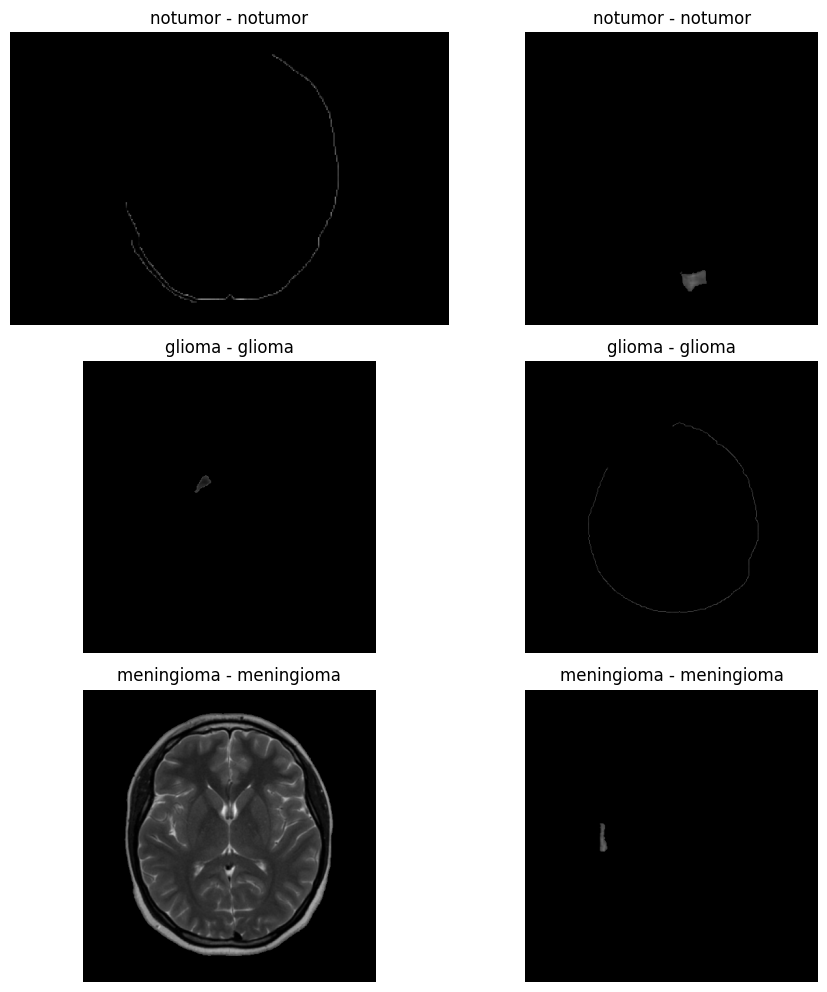

In [11]:
contour_masks = []  
segmented_images = []  

original_indices = list(range(len(sampled_images)))
random.shuffle(original_indices)

for idx in original_indices:
    edge_img = edge_detected_images[idx]
    contours = cv.findContours(edge_img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[-2]
    if contours:
        largest_contour = sorted(contours, key=cv.contourArea, reverse=True)[0]
        contour_mask = np.zeros(edge_img.shape[:2], dtype='uint8')
        cv.drawContours(contour_mask, [largest_contour], -1, 255, -1)
        contour_masks.append(contour_mask)

        combined_image = cv.bitwise_and(sampled_images[idx], sampled_images[idx], mask=contour_mask)
        segmented_images.append(cv.cvtColor(combined_image, cv.COLOR_BGR2RGB))

fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

index = 0
for row, label in enumerate(labels_to_display):
    for col in range(max_images_per_label):
        if index < len(segmented_images):
            ax = axes[row, col]
            ax.imshow(segmented_images[index])
            ax.set_title(f"{label} - {sampled_labels[index]}")
            ax.axis('off')
            index += 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()

deteksi tepi 

In [12]:
def sobel_edge_detection(image):
    # If image is already grayscale, ensure it's in uint8 format
    if len(image.shape) == 3 and image.shape[-1] == 3:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray = image.astype(np.uint8)
    else:
        raise ValueError("Unsupported image format. Expected BGR or grayscale image.")

    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    rows, cols = gray.shape
    edges = np.zeros((rows, cols), dtype=np.uint8)

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            gx = np.sum(Gx * gray[i-1:i+2, j-1:j+2])
            gy = np.sum(Gy * gray[i-1:i+2, j-1:j+2])
            magnitude = np.sqrt(gx**2 + gy**2)
            edges[i, j] = min(255, int(magnitude))

    return edges


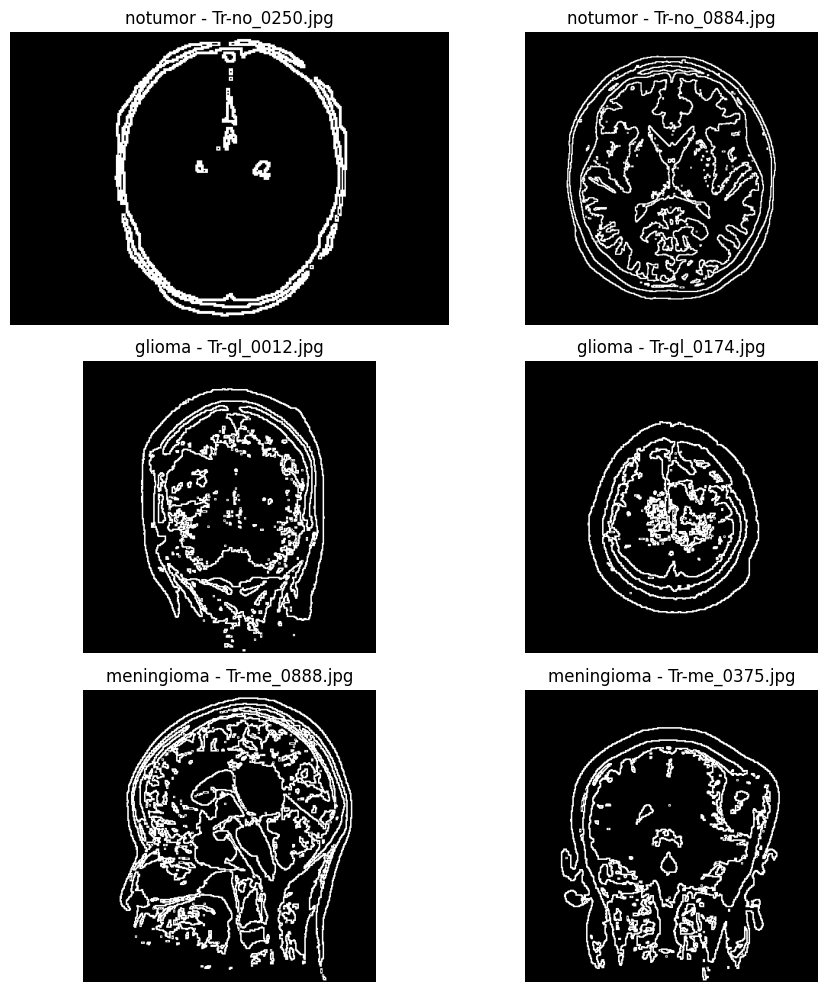

In [13]:
# Apply edge detection (Sobel)
edge_detected_images = []
for img in thresholded_images:
    edge_detected_img = sobel_edge_detection(img)
    edge_detected_images.append(edge_detected_img)

# Display edge detected images
fig, axes = plt.subplots(nrows=len(labels_to_display), ncols=max_images_per_label, figsize=(10, 10))

index = 0
for row, label in enumerate(labels_to_display):
    filtered_filenames = [filename for filename, img_label in zip(filenames, labels) if img_label == label]
    random.shuffle(filtered_filenames)
    for col in range(max_images_per_label):
        if index < len(edge_detected_images):
            ax = axes[row, col]
            ax.imshow(edge_detected_images[index], cmap='gray')
            ax.set_title(f"{label} - {filtered_filenames[index % len(filtered_filenames)]}")
            ax.axis('off')
            index += 1

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.tight_layout(pad=1.0)
plt.show()


Ekstraksi Fitur

In [20]:
import os
import pandas as pd
import numpy as np
import cv2 as cv
from skimage.feature import graycomatrix, graycoprops

def insertGambar(folder):
    images = [] 
    filenames = [] 
    labels = [] 

    for label in os.listdir(folder): 
        for filename in os.listdir(os.path.join(folder, label)): 
            img = cv.imread(os.path.join(folder, label, filename), cv.IMREAD_GRAYSCALE) 
            filenames.append(filename) 
            labels.append(label) 
            if img is not None: 
                images.append(img) 
    return images, filenames, labels 

images, filenames, labels = insertGambar("dataset")

def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    for i, image in enumerate(images):
        image = image.astype(int)
        glcm = graycomatrix(image, distances, angles, levels, symmetric, normed)
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                feat_a = graycoprops(glcm, feature)[0, int(angle*4/np.pi)]
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        for angle, angle_label in zip(angles, angle_labels):
            asm = np.sum(glcm[:, :, 0, int(angle*4/np.pi)]**2)
            entropy = -np.sum(glcm[:, :, 0, int(angle*4/np.pi)]*np.log2(glcm[:, :, 0, int(angle*4/np.pi)] + np.finfo(float).eps))
            df_data.loc[i, f'asm_{angle_label}'] = asm
            df_data.loc[i, f'entropy_{angle_label}'] = entropy
        df_data.loc[i, 'label'] = labels[i]
    return df_data

glcm_features = extract_glcm_features(images, labels)


In [19]:
glcm_features

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,label
0,559.777906,509.452248,344.406824,556.285228,10.192015,9.926541,7.828915,10.320211,0.525216,0.506688,...,0.853133,0.067387,8.726715,0.062852,8.819382,0.069917,8.548557,0.062932,8.835619,glioma
1,530.754831,495.865564,307.989568,500.072653,9.848681,9.833882,7.633190,9.827287,0.486170,0.470862,...,0.868677,0.055617,9.068196,0.053642,9.132493,0.059928,8.860055,0.053618,9.129348,glioma
2,548.509885,546.982996,382.903399,547.482555,10.044109,10.212761,8.186606,10.177506,0.474662,0.460895,...,0.837063,0.051748,9.272096,0.050389,9.327289,0.056419,9.053657,0.050510,9.327037,glioma
3,374.178778,347.123043,230.759188,357.793675,8.153276,8.027075,6.442797,8.200466,0.500121,0.485695,...,0.770719,0.057153,8.732030,0.055035,8.783869,0.060781,8.543866,0.055052,8.806700,glioma
4,406.292845,400.307273,295.610546,435.152009,9.210922,9.280248,7.684395,9.631743,0.419285,0.404998,...,0.806638,0.045089,9.627480,0.044787,9.672618,0.050168,9.401011,0.044935,9.683259,glioma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,928.322647,998.533678,801.303667,1013.067088,16.105817,16.977020,14.529057,17.053551,0.349622,0.303892,...,0.729049,0.023916,10.248851,0.017457,10.425554,0.022540,10.188954,0.017551,10.436551,notumor
4251,3459.426343,3703.518192,2938.759879,3727.699433,28.247273,30.071211,25.518707,29.823099,0.416233,0.401798,...,0.478740,0.075795,9.589678,0.069139,9.741021,0.080263,9.492527,0.069923,9.724616,notumor
4252,2144.379152,2368.008497,1959.990061,2434.523720,21.268404,22.702791,19.769293,23.124486,0.384732,0.372960,...,0.645282,0.036249,9.736841,0.035993,9.821292,0.051475,9.475415,0.035741,9.838078,notumor
4253,6012.688196,6585.322284,5059.342706,6496.109586,47.320134,50.279571,42.648091,49.909338,0.201863,0.186003,...,0.436881,0.010478,12.145671,0.009034,12.265758,0.012596,12.048846,0.009174,12.260068,notumor
